# Can we predict if a Transit is due to a Brown Dwarf Star or a Planet using Machine Learning? Part 2 - Deep Learning with PyTorch & Keras

### Please see Part 1 ( https://github.com/the-dr-eric-r/DS_Portfolio/blob/main/Exoplanet_DS_Portfolio/exoplanet_or_browndwarf_ER.ipynb ) of this problem for the overview. The following exercise if designed to get experience with Deep Learning...

I recently completed a few courses in Deep Learning (each approximately 4 hours in videos+guided exercises)... 

- Intro To Deep Learning - *Kaggle*
- Introduction to Deep Learning with Pytorch - *DataCamp*
- Introduction to Deep Learning with Keras - *DataCamp*
- Advanced Deep Learning with Keras - *DataCamp*

Courses however do not translate to experience. I felt the best way to make sure that I understood the basics of Neural Networks and using Deep Learning tools was to do a comparison between different common Deep Learning libraries, PyTorch and Keras.

The PyTorch and Keras models will both contain the same number of hidden layers and epochs in the fitting. We use XGBoost as a comparison case (as this usually scores quite well), noting that it is not a neural network but a tree ensemble method. I chose this because I hear about it all the time on a few podcasts I follow, and in studying this came across the following article: *Tabular Data: Deep Learning is Not All You Need* - https://arxiv.org/abs/2106.03253

Before attempting this on my own compiled Exoplanet/Brown Dwarf data, I tested this code on the Iris Classification problem (properly classify Iris flower species noting the petal/sepal properties, a ML-Bootcamp Right-of-Passage). This example is not included here.

I referenced the following articles / code sources that approach this problem, and modify them based on what I learned in the above courses, as well as to align properties of the Neural Network.

- **Building a Multiclass Classification Model in PyTorch** - https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/
- **Iris Classification using a Keras Neural Network** - https://medium.com/@manwill/iris-classification-using-a-keras-neural-network-39d735d11fda
- **Keras Multi-class Classification using IRIS Dataset** - https://vitalflux.com/keras-multi-class-classification-using-iris-dataset/
- **A Simple XGBoost Tutorial Using the Iris Dataset** - https://www.kdnuggets.com/2017/03/simple-xgboost-tutorial-iris-dataset.html


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import copy

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder  
from sklearn.metrics import precision_score, accuracy_score

#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

#keras / tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.utils import to_categorical

#xgboost
import xgboost as xgb

In [2]:
# read data and apply one-hot encoding
data = pd.read_csv("exoplanet_plus_browndwarf_deep.csv")

<AxesSubplot:>

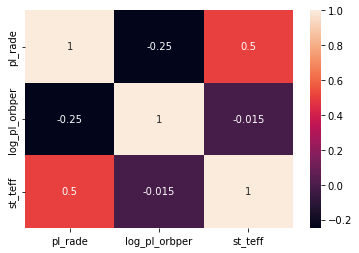

In [3]:
sns.heatmap(data.corr(), annot = True)

In [4]:
X = data.iloc[:, 0:3]
y = data.iloc[:, 3:]

le = LabelEncoder()  
y_xg = le.fit_transform(y) #for xgboost
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(y)
y = ohe.transform(y) #for keras / pytorch

# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X_pt = torch.tensor(X.values, dtype=torch.float32)
y_pt = torch.tensor(y, dtype=torch.float32)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Train / Test Split

In [5]:
ts=0.7 #split fraction

#Pytorch
X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(X_pt, y_pt, train_size=ts, shuffle=True)
#Keras
X_train_kr, X_test_kr, y_train_kr, y_test_kr = train_test_split(X, y, train_size=ts, shuffle=True)
#XGBoost
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(X, y_xg, train_size=ts, shuffle=True)

# Neural Network for Pytorch / Keras
# [3 inputs] -> [8 hidden neurons] -> [3 (classes) outputs]

In [6]:
# prepare model and training parameters
n_hidden = 8
n_epochs = 100
batch_size = 5
inp_shape = X.shape[1]

## Build Pytorch Model

In [7]:
# The 'Building a Multiclass Classification Model in PyTorch' article created the model as a 'Class'.
# I have never created a class before, so I had to sit a spell and make some sense out of it 
# I chose to keep it as it is a very tidy way of modelling

class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(inp_shape, n_hidden)
        self.act = nn.ReLU() #use the same activation in Keras model
        self.output = nn.Linear(n_hidden, 3)
# https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html
#      it's the forward function that defines the network structure
    def forward(self, x): 
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

In [8]:
 # loss metric and optimizer
model_pt = Multiclass()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001)
 
# prepare model and training parameters
batches_per_epoch = len(X_train_pt) // batch_size
 
best_acc_pt = - np.inf   # init to negative infinity
best_weights_pt = None
train_loss_pt = []
train_acc_pt = []
test_loss_pt = []
test_acc_pt = []

## Build Keras Model

In [9]:
model_kr = Sequential()
model_kr.add(layers.Dense(n_hidden, activation='relu', input_shape=(inp_shape,))) #use the same activation in Pytorch model
model_kr.add(layers.Dense(3, activation='softmax'))

model_kr.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

2023-08-09 11:20:36.908970: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare / Train XGBoost Model

In [10]:
#Next you need to create the Xgboost specific DMatrix data format from the numpy array. 
dtrain = xgb.DMatrix(X_train_xg, label=y_train_xg)
dtest = xgb.DMatrix(X_test_xg, label=y_test_xg)

# set xgboost params
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
#num_round = 20  # the number of training iterations
num_round = n_epochs # the number of training iterations

## Train Pytorch Model

In [11]:
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model_pt.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_pt[start:start+batch_size]
            y_batch = y_train_pt[start:start+batch_size]
            # forward pass
            y_pred = model_pt(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model_pt.eval()
    y_pred = model_pt(X_test_pt)
    ce = loss_fn(y_pred, y_test_pt)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test_pt, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_pt.append(np.mean(epoch_loss))
    train_acc_pt.append(np.mean(epoch_acc))
    test_loss_pt.append(ce)
    test_acc_pt.append(acc)
    if acc > best_acc_pt:
        best_acc_pt = acc
        best_weights_pt = copy.deepcopy(model_pt.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

Epoch 0: 100%|████████| 124/124 [00:00<00:00, 189.63batch/s, acc=0.6, loss=1.66]


Epoch 0 validation: Cross-entropy=5.46, Accuracy=50.0%


Epoch 1: 100%|███████| 124/124 [00:00<00:00, 232.06batch/s, acc=0.6, loss=0.546]


Epoch 1 validation: Cross-entropy=0.92, Accuracy=70.5%


Epoch 2: 100%|███████| 124/124 [00:00<00:00, 237.88batch/s, acc=0.6, loss=0.541]


Epoch 2 validation: Cross-entropy=1.90, Accuracy=69.4%


Epoch 3: 100%|████████| 124/124 [00:00<00:00, 234.36batch/s, acc=0.6, loss=2.44]


Epoch 3 validation: Cross-entropy=4.84, Accuracy=50.0%


Epoch 4: 100%|███████| 124/124 [00:00<00:00, 239.42batch/s, acc=0.6, loss=0.828]


Epoch 4 validation: Cross-entropy=1.64, Accuracy=59.3%


Epoch 5: 100%|███████| 124/124 [00:00<00:00, 231.40batch/s, acc=0.6, loss=0.511]


Epoch 5 validation: Cross-entropy=1.04, Accuracy=73.1%


Epoch 6: 100%|███████| 124/124 [00:00<00:00, 238.15batch/s, acc=0.6, loss=0.726]


Epoch 6 validation: Cross-entropy=1.42, Accuracy=71.6%


Epoch 7: 100%|████████| 124/124 [00:00<00:00, 239.75batch/s, acc=0.6, loss=1.44]


Epoch 7 validation: Cross-entropy=3.00, Accuracy=50.0%


Epoch 8: 100%|████████| 124/124 [00:00<00:00, 229.00batch/s, acc=0.6, loss=2.13]


Epoch 8 validation: Cross-entropy=4.74, Accuracy=50.0%


Epoch 9: 100%|████████| 124/124 [00:00<00:00, 191.24batch/s, acc=0.6, loss=1.05]


Epoch 9 validation: Cross-entropy=4.79, Accuracy=50.0%


Epoch 10: 100%|███████| 124/124 [00:00<00:00, 214.31batch/s, acc=0.6, loss=1.35]


Epoch 10 validation: Cross-entropy=3.63, Accuracy=50.0%


Epoch 11: 100%|███████| 124/124 [00:00<00:00, 201.79batch/s, acc=0.6, loss=1.23]


Epoch 11 validation: Cross-entropy=5.52, Accuracy=50.0%


Epoch 12: 100%|██████| 124/124 [00:00<00:00, 210.84batch/s, acc=0.6, loss=0.974]


Epoch 12 validation: Cross-entropy=5.50, Accuracy=50.0%


Epoch 13: 100%|██████████| 124/124 [00:00<00:00, 204.58batch/s, acc=0.6, loss=1]


Epoch 13 validation: Cross-entropy=3.39, Accuracy=50.0%


Epoch 14: 100%|██████| 124/124 [00:00<00:00, 191.77batch/s, acc=0.6, loss=0.437]


Epoch 14 validation: Cross-entropy=3.74, Accuracy=50.0%


Epoch 15: 100%|██████| 124/124 [00:00<00:00, 163.21batch/s, acc=0.6, loss=0.854]


Epoch 15 validation: Cross-entropy=3.93, Accuracy=50.0%


Epoch 16: 100%|██████| 124/124 [00:00<00:00, 158.02batch/s, acc=0.8, loss=0.435]


Epoch 16 validation: Cross-entropy=3.34, Accuracy=50.0%


Epoch 17: 100%|██████| 124/124 [00:00<00:00, 168.86batch/s, acc=0.8, loss=0.334]


Epoch 17 validation: Cross-entropy=3.79, Accuracy=50.0%


Epoch 18: 100%|██████| 124/124 [00:00<00:00, 158.70batch/s, acc=0.8, loss=0.651]


Epoch 18 validation: Cross-entropy=2.93, Accuracy=50.0%


Epoch 19: 100%|██████| 124/124 [00:00<00:00, 154.42batch/s, acc=0.6, loss=0.376]


Epoch 19 validation: Cross-entropy=3.61, Accuracy=50.0%


Epoch 20: 100%|██████| 124/124 [00:00<00:00, 182.42batch/s, acc=0.8, loss=0.442]


Epoch 20 validation: Cross-entropy=3.49, Accuracy=50.0%


Epoch 21: 100%|████████| 124/124 [00:00<00:00, 189.50batch/s, acc=1, loss=0.315]


Epoch 21 validation: Cross-entropy=3.97, Accuracy=50.0%


Epoch 22: 100%|██████| 124/124 [00:00<00:00, 207.51batch/s, acc=0.8, loss=0.585]


Epoch 22 validation: Cross-entropy=2.79, Accuracy=50.0%


Epoch 23: 100%|██████| 124/124 [00:00<00:00, 169.92batch/s, acc=0.8, loss=0.298]


Epoch 23 validation: Cross-entropy=3.73, Accuracy=50.0%


Epoch 24: 100%|██████| 124/124 [00:00<00:00, 170.48batch/s, acc=0.6, loss=0.535]


Epoch 24 validation: Cross-entropy=3.77, Accuracy=50.0%


Epoch 25: 100%|██████| 124/124 [00:00<00:00, 197.84batch/s, acc=0.8, loss=0.358]


Epoch 25 validation: Cross-entropy=2.96, Accuracy=50.0%


Epoch 26: 100%|██████| 124/124 [00:00<00:00, 178.91batch/s, acc=0.8, loss=0.366]


Epoch 26 validation: Cross-entropy=2.91, Accuracy=50.0%


Epoch 27: 100%|████████| 124/124 [00:00<00:00, 145.60batch/s, acc=1, loss=0.316]


Epoch 27 validation: Cross-entropy=3.41, Accuracy=50.0%


Epoch 28: 100%|████████| 124/124 [00:00<00:00, 187.72batch/s, acc=1, loss=0.322]


Epoch 28 validation: Cross-entropy=3.54, Accuracy=50.0%


Epoch 29: 100%|██████| 124/124 [00:00<00:00, 182.49batch/s, acc=0.8, loss=0.613]


Epoch 29 validation: Cross-entropy=2.25, Accuracy=57.1%


Epoch 30: 100%|██████| 124/124 [00:00<00:00, 200.37batch/s, acc=0.8, loss=0.304]


Epoch 30 validation: Cross-entropy=3.83, Accuracy=50.0%


Epoch 31: 100%|████████| 124/124 [00:00<00:00, 207.57batch/s, acc=1, loss=0.276]


Epoch 31 validation: Cross-entropy=3.86, Accuracy=50.0%


Epoch 32: 100%|███████| 124/124 [00:00<00:00, 142.52batch/s, acc=0.6, loss=1.35]


Epoch 32 validation: Cross-entropy=1.90, Accuracy=73.9%


Epoch 33: 100%|██████| 124/124 [00:00<00:00, 174.00batch/s, acc=0.8, loss=0.398]


Epoch 33 validation: Cross-entropy=3.35, Accuracy=50.0%


Epoch 34: 100%|██████| 124/124 [00:00<00:00, 157.55batch/s, acc=0.8, loss=0.431]


Epoch 34 validation: Cross-entropy=3.40, Accuracy=50.0%


Epoch 35: 100%|███████| 124/124 [00:00<00:00, 159.42batch/s, acc=0.6, loss=1.61]


Epoch 35 validation: Cross-entropy=1.86, Accuracy=73.1%


Epoch 36: 100%|███████| 124/124 [00:00<00:00, 151.74batch/s, acc=0.8, loss=1.18]


Epoch 36 validation: Cross-entropy=3.84, Accuracy=73.5%


Epoch 37: 100%|██████| 124/124 [00:01<00:00, 109.55batch/s, acc=0.8, loss=0.566]


Epoch 37 validation: Cross-entropy=3.33, Accuracy=50.7%


Epoch 38: 100%|██████| 124/124 [00:01<00:00, 117.66batch/s, acc=0.8, loss=0.552]


Epoch 38 validation: Cross-entropy=3.16, Accuracy=52.2%


Epoch 39: 100%|██████| 124/124 [00:00<00:00, 180.67batch/s, acc=0.8, loss=0.903]


Epoch 39 validation: Cross-entropy=2.04, Accuracy=72.0%


Epoch 40: 100%|███████| 124/124 [00:00<00:00, 178.80batch/s, acc=0.6, loss=1.38]


Epoch 40 validation: Cross-entropy=1.38, Accuracy=73.9%


Epoch 41: 100%|████████| 124/124 [00:00<00:00, 180.14batch/s, acc=0.8, loss=1.1]


Epoch 41 validation: Cross-entropy=1.97, Accuracy=73.5%


Epoch 42: 100%|███████| 124/124 [00:00<00:00, 183.84batch/s, acc=0.8, loss=1.15]


Epoch 42 validation: Cross-entropy=1.93, Accuracy=73.9%


Epoch 43: 100%|██████| 124/124 [00:00<00:00, 193.56batch/s, acc=0.8, loss=0.745]


Epoch 43 validation: Cross-entropy=1.81, Accuracy=73.1%


Epoch 44: 100%|██████| 124/124 [00:00<00:00, 204.92batch/s, acc=0.8, loss=0.846]


Epoch 44 validation: Cross-entropy=2.25, Accuracy=74.6%


Epoch 45: 100%|██████| 124/124 [00:00<00:00, 189.71batch/s, acc=0.8, loss=0.628]


Epoch 45 validation: Cross-entropy=2.37, Accuracy=67.5%


Epoch 46: 100%|███████| 124/124 [00:00<00:00, 197.35batch/s, acc=0.8, loss=1.31]


Epoch 46 validation: Cross-entropy=2.29, Accuracy=74.3%


Epoch 47: 100%|██████| 124/124 [00:00<00:00, 213.94batch/s, acc=0.8, loss=0.655]


Epoch 47 validation: Cross-entropy=2.59, Accuracy=67.9%


Epoch 48: 100%|██████| 124/124 [00:00<00:00, 191.27batch/s, acc=0.6, loss=0.981]


Epoch 48 validation: Cross-entropy=2.97, Accuracy=58.2%


Epoch 49: 100%|██████| 124/124 [00:00<00:00, 209.60batch/s, acc=0.8, loss=0.597]


Epoch 49 validation: Cross-entropy=2.70, Accuracy=72.0%


Epoch 50: 100%|██████| 124/124 [00:00<00:00, 242.02batch/s, acc=0.8, loss=0.861]


Epoch 50 validation: Cross-entropy=2.38, Accuracy=74.3%


Epoch 51: 100%|██████| 124/124 [00:00<00:00, 221.46batch/s, acc=0.8, loss=0.928]


Epoch 51 validation: Cross-entropy=2.47, Accuracy=74.6%


Epoch 52: 100%|███████| 124/124 [00:00<00:00, 219.51batch/s, acc=0.8, loss=1.08]


Epoch 52 validation: Cross-entropy=1.39, Accuracy=73.9%


Epoch 53: 100%|███████| 124/124 [00:00<00:00, 219.77batch/s, acc=0.8, loss=1.14]


Epoch 53 validation: Cross-entropy=1.82, Accuracy=73.9%


Epoch 54: 100%|██████| 124/124 [00:00<00:00, 225.80batch/s, acc=0.8, loss=0.922]


Epoch 54 validation: Cross-entropy=2.56, Accuracy=74.6%


Epoch 55: 100%|██████| 124/124 [00:00<00:00, 219.18batch/s, acc=0.6, loss=0.525]


Epoch 55 validation: Cross-entropy=2.43, Accuracy=74.6%


Epoch 56: 100%|███████| 124/124 [00:00<00:00, 217.47batch/s, acc=0.8, loss=1.23]


Epoch 56 validation: Cross-entropy=1.95, Accuracy=73.9%


Epoch 57: 100%|██████| 124/124 [00:00<00:00, 223.57batch/s, acc=0.8, loss=0.927]


Epoch 57 validation: Cross-entropy=2.21, Accuracy=74.6%


Epoch 58: 100%|██████| 124/124 [00:00<00:00, 219.15batch/s, acc=0.8, loss=0.916]


Epoch 58 validation: Cross-entropy=1.93, Accuracy=73.9%


Epoch 59: 100%|███████| 124/124 [00:00<00:00, 218.04batch/s, acc=0.8, loss=1.19]


Epoch 59 validation: Cross-entropy=2.70, Accuracy=73.5%


Epoch 60: 100%|████████| 124/124 [00:00<00:00, 224.26batch/s, acc=1, loss=0.368]


Epoch 60 validation: Cross-entropy=1.81, Accuracy=73.5%


Epoch 61: 100%|██████| 124/124 [00:00<00:00, 215.58batch/s, acc=0.8, loss=0.773]


Epoch 61 validation: Cross-entropy=2.42, Accuracy=74.3%


Epoch 62: 100%|███████| 124/124 [00:00<00:00, 225.60batch/s, acc=0.8, loss=1.08]


Epoch 62 validation: Cross-entropy=2.14, Accuracy=74.3%


Epoch 63: 100%|███████| 124/124 [00:00<00:00, 203.21batch/s, acc=0.8, loss=1.07]


Epoch 63 validation: Cross-entropy=2.58, Accuracy=74.3%


Epoch 64: 100%|██████| 124/124 [00:00<00:00, 220.43batch/s, acc=0.8, loss=0.871]


Epoch 64 validation: Cross-entropy=2.24, Accuracy=74.6%


Epoch 65: 100%|███████| 124/124 [00:00<00:00, 231.74batch/s, acc=0.8, loss=1.03]


Epoch 65 validation: Cross-entropy=1.64, Accuracy=73.9%


Epoch 66: 100%|███████| 124/124 [00:00<00:00, 207.38batch/s, acc=0.8, loss=1.08]


Epoch 66 validation: Cross-entropy=2.52, Accuracy=73.9%


Epoch 67: 100%|██████| 124/124 [00:00<00:00, 177.61batch/s, acc=0.8, loss=0.801]


Epoch 67 validation: Cross-entropy=2.26, Accuracy=75.0%


Epoch 68: 100%|██████| 124/124 [00:00<00:00, 174.99batch/s, acc=0.8, loss=0.279]


Epoch 68 validation: Cross-entropy=2.31, Accuracy=73.5%


Epoch 69: 100%|██████| 124/124 [00:00<00:00, 178.59batch/s, acc=0.8, loss=0.642]


Epoch 69 validation: Cross-entropy=2.54, Accuracy=74.3%


Epoch 70: 100%|████████| 124/124 [00:00<00:00, 187.16batch/s, acc=1, loss=0.228]


Epoch 70 validation: Cross-entropy=2.40, Accuracy=74.3%


Epoch 71: 100%|██████| 124/124 [00:00<00:00, 164.57batch/s, acc=0.8, loss=0.367]


Epoch 71 validation: Cross-entropy=2.56, Accuracy=74.3%


Epoch 72: 100%|███████| 124/124 [00:00<00:00, 187.78batch/s, acc=0.8, loss=1.03]


Epoch 72 validation: Cross-entropy=2.51, Accuracy=74.3%


Epoch 73: 100%|██████████| 124/124 [00:00<00:00, 134.21batch/s, acc=0.8, loss=1]


Epoch 73 validation: Cross-entropy=2.07, Accuracy=73.5%


Epoch 74: 100%|███████| 124/124 [00:00<00:00, 183.89batch/s, acc=0.8, loss=1.04]


Epoch 74 validation: Cross-entropy=1.80, Accuracy=74.3%


Epoch 75: 100%|████████| 124/124 [00:00<00:00, 173.67batch/s, acc=0.8, loss=1.1]


Epoch 75 validation: Cross-entropy=2.72, Accuracy=73.9%


Epoch 76: 100%|██████| 124/124 [00:00<00:00, 187.21batch/s, acc=0.8, loss=0.797]


Epoch 76 validation: Cross-entropy=1.86, Accuracy=74.3%


Epoch 77: 100%|████████| 124/124 [00:00<00:00, 185.63batch/s, acc=1, loss=0.212]


Epoch 77 validation: Cross-entropy=3.20, Accuracy=73.5%


Epoch 78: 100%|██████| 124/124 [00:00<00:00, 215.30batch/s, acc=0.8, loss=0.304]


Epoch 78 validation: Cross-entropy=2.25, Accuracy=74.3%


Epoch 79: 100%|████████| 124/124 [00:00<00:00, 190.08batch/s, acc=1, loss=0.211]


Epoch 79 validation: Cross-entropy=3.81, Accuracy=72.8%


Epoch 80: 100%|██████████| 124/124 [00:00<00:00, 211.85batch/s, acc=1, loss=0.3]


Epoch 80 validation: Cross-entropy=2.03, Accuracy=73.5%


Epoch 81: 100%|██████| 124/124 [00:00<00:00, 199.18batch/s, acc=0.8, loss=0.874]


Epoch 81 validation: Cross-entropy=1.49, Accuracy=74.3%


Epoch 82: 100%|██████| 124/124 [00:00<00:00, 211.64batch/s, acc=0.8, loss=0.233]


Epoch 82 validation: Cross-entropy=2.68, Accuracy=73.5%


Epoch 83: 100%|████████| 124/124 [00:00<00:00, 215.77batch/s, acc=1, loss=0.208]


Epoch 83 validation: Cross-entropy=2.83, Accuracy=73.9%


Epoch 84: 100%|██████| 124/124 [00:00<00:00, 227.15batch/s, acc=0.8, loss=0.431]


Epoch 84 validation: Cross-entropy=2.02, Accuracy=73.5%


Epoch 85: 100%|██████| 124/124 [00:00<00:00, 213.55batch/s, acc=0.8, loss=0.648]


Epoch 85 validation: Cross-entropy=1.82, Accuracy=74.3%


Epoch 86: 100%|██████| 124/124 [00:00<00:00, 219.01batch/s, acc=0.8, loss=0.766]


Epoch 86 validation: Cross-entropy=2.45, Accuracy=73.9%


Epoch 87: 100%|██████| 124/124 [00:00<00:00, 233.92batch/s, acc=0.8, loss=0.508]


Epoch 87 validation: Cross-entropy=2.26, Accuracy=73.5%


Epoch 88: 100%|██████| 124/124 [00:00<00:00, 231.32batch/s, acc=0.8, loss=0.776]


Epoch 88 validation: Cross-entropy=1.73, Accuracy=74.3%


Epoch 89: 100%|██████| 124/124 [00:00<00:00, 201.20batch/s, acc=0.8, loss=0.947]


Epoch 89 validation: Cross-entropy=2.68, Accuracy=74.3%


Epoch 90: 100%|██████| 124/124 [00:00<00:00, 231.59batch/s, acc=0.8, loss=0.734]


Epoch 90 validation: Cross-entropy=2.62, Accuracy=73.9%


Epoch 91: 100%|██████| 124/124 [00:00<00:00, 234.01batch/s, acc=0.8, loss=0.801]


Epoch 91 validation: Cross-entropy=1.80, Accuracy=74.6%


Epoch 92: 100%|██████| 124/124 [00:00<00:00, 227.98batch/s, acc=0.8, loss=0.694]


Epoch 92 validation: Cross-entropy=1.97, Accuracy=74.3%


Epoch 93: 100%|██████| 124/124 [00:00<00:00, 238.32batch/s, acc=0.8, loss=0.636]


Epoch 93 validation: Cross-entropy=2.86, Accuracy=73.1%


Epoch 94: 100%|██████| 124/124 [00:00<00:00, 206.58batch/s, acc=0.8, loss=0.561]


Epoch 94 validation: Cross-entropy=3.44, Accuracy=74.3%


Epoch 95: 100%|██████| 124/124 [00:00<00:00, 165.90batch/s, acc=0.8, loss=0.972]


Epoch 95 validation: Cross-entropy=2.00, Accuracy=74.3%


Epoch 96: 100%|██████| 124/124 [00:00<00:00, 202.49batch/s, acc=0.8, loss=0.931]


Epoch 96 validation: Cross-entropy=1.66, Accuracy=74.3%


Epoch 97: 100%|██████| 124/124 [00:00<00:00, 201.17batch/s, acc=0.8, loss=0.664]


Epoch 97 validation: Cross-entropy=2.62, Accuracy=73.5%


Epoch 98: 100%|███████| 124/124 [00:00<00:00, 207.14batch/s, acc=0.8, loss=0.77]


Epoch 98 validation: Cross-entropy=2.15, Accuracy=73.9%


Epoch 99: 100%|██████| 124/124 [00:00<00:00, 206.43batch/s, acc=0.8, loss=0.931]


Epoch 99 validation: Cross-entropy=1.95, Accuracy=74.3%


## Train Keras Model

In [12]:
history_kr = model_kr.fit(X_train_kr, y_train_kr, epochs=n_epochs, 
                          batch_size=batch_size, validation_data=(X_test_kr, y_test_kr))

2023-08-09 11:21:41.993656: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
125/125 [==============================] - 1s 3ms/step - loss: 244.0272 - accuracy: 0.5192 - val_loss: 62.3412 - val_accuracy: 0.4701
Epoch 2/100
125/125 [==============================] - 0s 1ms/step - loss: 76.5384 - accuracy: 0.6699 - val_loss: 45.5520 - val_accuracy: 0.7388
Epoch 3/100
125/125 [==============================] - 0s 1ms/step - loss: 54.6190 - accuracy: 0.6971 - val_loss: 30.6567 - val_accuracy: 0.7351
Epoch 4/100
125/125 [==============================] - 0s 1ms/step - loss: 35.6589 - accuracy: 0.6346 - val_loss: 19.6185 - val_accuracy: 0.4701
Epoch 5/100
125/125 [==============================] - 0s 1ms/step - loss: 21.2027 - accuracy: 0.5769 - val_loss: 10.3080 - val_accuracy: 0.5000
Epoch 6/100
125/125 [==============================] - 0s 1ms/step - loss: 8.2628 - accuracy: 0.5449 - val_loss: 1.1153 - val_accuracy: 0.5448
Epoch 7/100
125/125 [==============================] - 0s 1ms/step - loss: 1.0932 - accuracy: 0.5176 - val_loss: 1.8879 - val_accur

Epoch 58/100
125/125 [==============================] - 0s 2ms/step - loss: 0.8796 - accuracy: 0.6699 - val_loss: 0.9997 - val_accuracy: 0.7388
Epoch 59/100
125/125 [==============================] - 0s 1ms/step - loss: 0.9465 - accuracy: 0.6747 - val_loss: 0.6832 - val_accuracy: 0.7164
Epoch 60/100
125/125 [==============================] - 0s 1ms/step - loss: 1.1043 - accuracy: 0.6202 - val_loss: 0.8399 - val_accuracy: 0.6455
Epoch 61/100
125/125 [==============================] - 0s 1ms/step - loss: 0.9920 - accuracy: 0.6699 - val_loss: 0.7221 - val_accuracy: 0.7201
Epoch 62/100
125/125 [==============================] - 0s 1ms/step - loss: 1.0086 - accuracy: 0.6362 - val_loss: 0.9855 - val_accuracy: 0.5784
Epoch 63/100
125/125 [==============================] - 0s 1ms/step - loss: 1.1095 - accuracy: 0.5929 - val_loss: 0.8341 - val_accuracy: 0.7313
Epoch 64/100
125/125 [==============================] - 0s 1ms/step - loss: 1.0430 - accuracy: 0.6330 - val_loss: 0.9300 - val_accuracy:

In [13]:
train_loss_kr, train_acc_kr = model_kr.evaluate(X_train_kr, y_train_kr)
test_loss_kr, test_acc_kr = model_kr.evaluate(X_test_kr, y_test_kr)

9/9 [==============================] - 0s 1ms/step - loss: 1.0272 - accuracy: 0.7015


## Train XGBoost

In [14]:
bst = xgb.train(param, dtrain, num_round)
preds_train_xg = bst.predict(dtrain)
preds_test_xg = bst.predict(dtest)

[11:22:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



## Plot

In [15]:
# Restore Pytorch best model
model_pt.load_state_dict(best_weights_pt)

<All keys matched successfully>

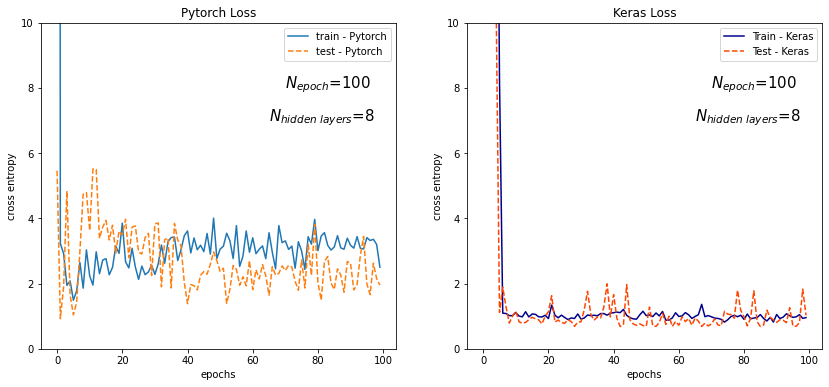

In [16]:
#Loss Figures
plt.figure(figsize=(14,6))
xp=70
yp=8

#graph parameters
ymax=10
wsize=15

plt.subplot(1, 2, 1)
plt.plot(train_loss_pt, label="train - Pytorch")
plt.plot(test_loss_pt, label="test - Pytorch", linestyle='--')
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.title('Pytorch Loss')
plt.text(xp,yp,r'$N_{epoch}$='+str(n_epochs),size=wsize)
plt.text(xp-5,yp-1,r'$N_{hidden \ layers}$='+str(n_hidden),size=wsize)
plt.ylim(0,ymax)
plt.legend()


plt.subplot(1, 2, 2)
# Plot the loss and accuracy
plt.plot(history_kr.history['loss'], label="Train - Keras", color='darkblue')
plt.plot(history_kr.history['val_loss'], label="Test - Keras", color='orangered', linestyle='--')
plt.title('Keras Loss')
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.ylim(0,ymax)
plt.legend()
plt.text(xp,yp,r'$N_{epoch}$='+str(n_epochs),size=wsize)
plt.text(xp-5,yp-1,r'$N_{hidden \ layers}$='+str(n_hidden),size=wsize)
#plt.show()

plt.show()

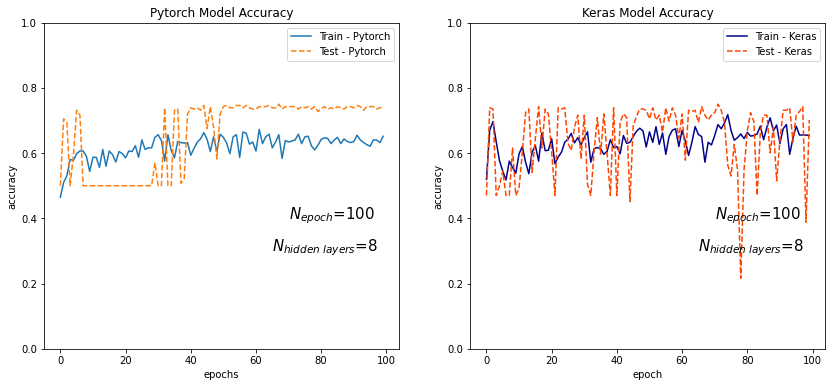

In [17]:
#Accuracy Figures
plt.figure(figsize=(14,6))
xp=70
yp=0.4

plt.subplot(1, 2, 1)
plt.plot(train_acc_pt, label="Train - Pytorch")
plt.plot(test_acc_pt, label="Test - Pytorch", linestyle='--')
plt.title('Pytorch Model Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.text(xp,yp,r'$N_{epoch}$='+str(n_epochs),size=wsize)
plt.text(xp-5,yp-0.1,r'$N_{hidden \ layers}$='+str(n_hidden),size=wsize)
plt.legend()
#plt.show()

plt.subplot(1, 2, 2)
plt.plot(history_kr.history['accuracy'], label="Train - Keras", color='darkblue')
plt.plot(history_kr.history['val_accuracy'], label="Test - Keras", color='orangered', linestyle='--')
plt.title('Keras Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.text(xp,yp,r'$N_{epoch}$='+str(n_epochs),size=wsize)
plt.text(xp-5,yp-0.1,r'$N_{hidden \ layers}$='+str(n_hidden),size=wsize)
plt.legend()

plt.show()

## Evaluation Metrics

In [18]:
print("Train Accuracy")
print('Pytorch Train Accuracy: ', max(train_acc_pt), ' | Pytorch Train Loss: ', min(train_loss_pt))
print('Keras Train Accuracy: ', train_acc_kr, ' | Keras Train Loss: ', train_loss_kr)

# extracting most confident predictions
best_preds_train_xg = np.asarray([np.argmax(line) for line in preds_train_xg])
#print("Train precision:", precision_score(y_train, best_preds_train, average='macro'))
print("XGBoost Train Accuracy:", accuracy_score(y_train_xg, best_preds_train_xg))

print(" ")
print("Test Accuracy")

print('Pytorch Test Accuracy: ', max(test_acc_pt), ' | Pytorch Test Loss: ', min(test_loss_pt))
print('Keras Test Accuracy: ', test_acc_kr, ' | Keras Test Loss: ', test_loss_kr)
# extracting most confident predictions
best_preds_test_xg = np.asarray([np.argmax(line) for line in preds_test_xg])
#print("Test precision:", precision_score(y_test, best_preds, average='macro'))
print("XGBoost Test Accuracy:", accuracy_score(y_test_xg, best_preds_test_xg))

#preds = bst.predict(dtest)
#best_preds = np.asarray([np.argmax(line) for line in preds])
      

Train Accuracy
Pytorch Train Accuracy:  0.6725806566255708  | Pytorch Train Loss:  1.490316902858115
Keras Train Accuracy:  0.7211538553237915  | Keras Train Loss:  1.0208295583724976
XGBoost Train Accuracy: 0.9775641025641025
 
Test Accuracy
Pytorch Test Accuracy:  0.75  | Pytorch Test Loss:  0.9230701923370361
Keras Test Accuracy:  0.7014925479888916  | Keras Test Loss:  1.0272098779678345
XGBoost Test Accuracy: 0.7574626865671642


In [19]:
'''
#XGBoost Model Dumping
# dump the models
bst.dump_model('dump.raw.txt')
bst_svm.dump_model('dump_svm.raw.txt')

# save the models for later
joblib.dump(bst, 'bst_model.pkl', compress=True)
joblib.dump(bst_svm, 'bst_svm_model.pkl', compress=True)
'''

"\n#XGBoost Model Dumping\n# dump the models\nbst.dump_model('dump.raw.txt')\nbst_svm.dump_model('dump_svm.raw.txt')\n\n# save the models for later\njoblib.dump(bst, 'bst_model.pkl', compress=True)\njoblib.dump(bst_svm, 'bst_svm_model.pkl', compress=True)\n"